In [1]:
# -*- coding: utf-8 -*-
import pandas as pd
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.cross_validation import train_test_split, cross_val_score
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, pairwise_distances
from sklearn.feature_extraction.text import TfidfVectorizer
import re
from sklearn.feature_extraction.text import TfidfTransformer
import os
os.environ["NLS_LANG"] = ".UTF8"
%matplotlib inline

C:\Users\Adi\DS\Anaconda2\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\Adi\DS\Anaconda2\lib\site-packages\sklearn\grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
data = pd.read_json('D:\\dropbox_zeev\\Dropbox\\Naya -DS - June 2017\\Final Project\\train.json', encoding='utf-8-sig')
# data = pd.read_json('X:\\Zeev\\Python\\whats_cooking.json',  encoding="utf-8") 
# data['ingredient'] = [','.join(z).strip() for z in data['ingredients']]
# i=0
# new_df_src = []
# while i < len(data['id']):
#     r_id=data['id'][i]
#     r_cuisine=data['cuisine'][i]
#     for ingrd in data['ingredients'][i]:
#         new_df_src.append({
# #             "id":i+1,
#             "cuisine_id":r_id,
#             "cuisine": r_cuisine,
#             "ingredients": ingrd
#         })
#     i+=1
# data = pd.DataFrame.from_dict(new_df_src)
data['ingredients_clean_string'] = [', '.join(z).strip() for z in data['ingredients']]
# data['ingredients_string'] = [' '.join([WordNetLemmatizer().lemmatize(re.sub('[^A-Za-z]', ' ', line))\
#                                            for line in lists]).strip() for lists in data['ingredients']]       
data.drop('ingredients', axis=1, inplace=True)
data = data.rename(columns={'ingredients_clean_string': 'ingredients' })
data['ingredients'] = data['ingredients'].str.encode("utf-8-sig", errors='strict') #encoding the DF
data = data.apply(lambda x: x.astype(str).str.lower()) #converting all the df to lower case

#removing all the adjectives
to_replace=['crushed','crumbles','ground','minced','powder','chopped','sliced,store bought low sodium','dressing,extract',\
            'yellow','yoplait','wild','whole wheat','rounds','undrain and chop,peeled','whole','unsweetened',\
           'unsalted','drain and flake','black','less sodium cooked','lowfat','low fat','low-fat',\
           'store bought low sodium','kosher','1%','2 1','2% ','25%','33%','40%','white',', thawed and squeezed dry',\
           'sweetened condensed ','refried','( oz.)','( oz.)','(10 oz.)','(10 oz.)','(14 oz.)', '(14.5 oz.)',\
            '(15 oz.)','frozen',', cook and drain','95%','8 ounc','blossoms','campbell\'s condensed','canadian',\
            'candied','® greek 100 berry pie','® greek 2% caramel ','canned',' mix','extra','large','extract',\
            'fat free','fat-free','flat','free range','free-range','fresh','freshly','gluten free',\
            'gluten-free','green','hellmann\' or best food light','hellmann\' or best food real','homemade'\
            'instant','kikkoman','jumbo','knorr','kraft','light','long','wish-bone','shredded','reduced fat',\
            'semisweet','self-raising','self-raising','seasoned','salt free','roasted','refrigerated',\
            'prepared','low sodium','-','inch','TRUE','uncooked','uncook','sweetened','sweeten','stuffed',\
            'striped','steamed','spiced','smoked','sliced','skinned','skinless','skin','skimmed','shaved','scrubbed',\
            'salted','rubbed','rolled','ripened','rendered','refined','reduced','pumpkinseed','puffed','processed',\
            'pressed','preshred','preserved','precooked','prebaked','poured','popped','pointed','pitted','pickled',\
            'peppered','peeled','pearled','parboiled','packed','oldfashioned','oilcured','nosaltadded',\
            'nonhydrogenated','melted','meatfilled','mashed','malted','kippered','jarred','iodized','iced',\
            'honeyflavored','hickoryflavored','herbed','hardboiled','grned','grilled','grated','grassfed',\
            'grapeseed','granulated','glazed','fried','freezedried','fleshed','flaxseed','flavored','flaked',\
            'filled','fermented','fattrimmed','fashioned','evaporated','enriched','dried','distilled','dillweed',\
            'diced','deviled','deveined','deepfried','cured','cuminseed','cultured','cubed','crystallized','crumbled',\
            'crispcooked','creamed','cracked','covered','corned','cooked','converted','condensed','compressed',\
            'coldsmoked','colaflavored','clotted','clarified','chocolatecovered','chipped','chilled','chickenflavored',\
            'carbonated','butterflied','butterflavored','brinecured','brewed','bones','boneless','bonein','boned','bone',\
            'boiled','allpurpose','achiote','96','43','15','14','10','8','7','5','4','3','2','1','0']     

for x in to_replace:
    data.ingredients.replace(x, "", regex=True, inplace=True)
data = data.dropna(axis=1)
data['ingredients'] = data['ingredients'].apply(lambda x: x.strip())
data['ingredients'] = data['ingredients'].apply(lambda x: x.replace('s+{2, }', ' '))

    
data.head()

,cuisine,id,ingredients
0,greek,10259,"﻿romaine lettuce, olives, grape tomatoes, gar..."
1,southern_us,25693,"﻿plain flour, pepper, salt, tomatoes, peppe..."
2,filipino,20130,"﻿eggs, pepper, salt, mayonaise, cooking oil, ..."
3,indian,22213,"﻿water, vegetable oil, wheat, salt"
4,indian,13162,"﻿ pepper, shallots, cornflour, cayenne pepper,..."


In [3]:
corpustr = data['ingredients']

vectorizer = TfidfVectorizer(stop_words='english',ngram_range = (1,2),analyzer="word",
                             max_df = .57 , binary=False , token_pattern=r'\w+' , sublinear_tf=False)
tfidf_matrix = vectorizer.fit_transform(corpustr)#.todense()
# feature_names = vectorizer.get_feature_names() 
# feature_names

In [ ]:
# print tfidf_matrix

In [4]:
X = tfidf_matrix #data.drop('cuisine', axis=1) 
y = data['cuisine']

X_train, X_test, y_train, y_test = \
    train_test_split(X, y, train_size=0.7, random_state=0)
rf_clf = RandomForestClassifier(n_estimators=250,verbose=1,n_jobs=-1)
bnb_clf = BernoulliNB()
lr_clf = LogisticRegression()
steps = [('rf',rf_clf),
         ('lr',lr_clf),
         ('bNB',bnb_clf)]
my_pipeline = Pipeline(steps)
# my_pipeline.fit(X_train, y_train)
print my_pipeline

Pipeline(steps=[('rf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estim...warm_start=False)), ('bNB', BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True))])


In [5]:
params = {'rf__max_depth': range(5, 15),
          'lr__C': [1, 10]}

gs = GridSearchCV(my_pipeline, param_grid=params)
gs.fit(X_train, y_train)
best_clf = gs.estimator
scores = cross_val_score(best_clf, X_train, y_train, scoring=None, cv=10)#'f1', cv=10)
def show_results(scores):
    print scores
    print "Mean:", scores.mean()
    print "Std:", scores.std()
    print 
show_results(scores)

[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:    4.7s finished
C:\Users\Adi\DS\Anaconda2\lib\site-packages\sklearn\utils\deprecation.py:70: DeprecationWarning: Function transform is deprecated; Support to use estimators as feature selectors will be removed in version 0.19. Use SelectFromModel instead.
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\Adi\DS\Anaconda2\lib\site-packages\sklearn\utils\deprecation.py:70: DeprecationWarning: Function transform is deprecated; Support to use estimators as feature selectors will be removed in version 0.19. Use SelectFromModel instead.
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\Adi\DS\Anaconda2\lib\site-packages\sklearn\utils\deprecation.py:70: DeprecationWarning: Function transform is deprecated; Support to use estimators as feature selectors will be removed in version 0.19. Use SelectFrom

[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:    6.0s finished
C:\Users\Adi\DS\Anaconda2\lib\site-packages\sklearn\utils\deprecation.py:70: DeprecationWarning: Function transform is deprecated; Support to use estimators as feature selectors will be removed in version 0.19. Use SelectFromModel instead.
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\Adi\DS\Anaconda2\lib\site-packages\sklearn\utils\deprecation.py:70: DeprecationWarning: Function transform is deprecated; Support to use estimators as feature selectors will be removed in version 0.19. Use SelectFromModel instead.
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\Adi\DS\Anaconda2\lib\site-packages\sklearn\utils\deprecation.py:70: DeprecationWarning: Function transform is deprecated; Support to use estimators as feature selectors will be removed in version 0.19. Use SelectFromModel instead.
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\Adi\DS\Anaconda2\lib\site-packages\sklearn\utils\d

C:\Users\Adi\DS\Anaconda2\lib\site-packages\sklearn\utils\deprecation.py:70: DeprecationWarning: Function transform is deprecated; Support to use estimators as feature selectors will be removed in version 0.19. Use SelectFromModel instead.
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\Adi\DS\Anaconda2\lib\site-packages\sklearn\utils\deprecation.py:70: DeprecationWarning: Function transform is deprecated; Support to use estimators as feature selectors will be removed in version 0.19. Use SelectFromModel instead.
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\Adi\DS\Anaconda2\lib\site-packages\sklearn\utils\deprecation.py:70: DeprecationWarning: Function transform is deprecated; Support to use estimators as feature selectors will be removed in version 0.19. Use SelectFromModel instead.
  warnings.warn(msg, category=DeprecationWarning)
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    7.4s
[Paral

C:\Users\Adi\DS\Anaconda2\lib\site-packages\sklearn\utils\deprecation.py:70: DeprecationWarning: Function transform is deprecated; Support to use estimators as feature selectors will be removed in version 0.19. Use SelectFromModel instead.
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\Adi\DS\Anaconda2\lib\site-packages\sklearn\utils\deprecation.py:70: DeprecationWarning: Function transform is deprecated; Support to use estimators as feature selectors will be removed in version 0.19. Use SelectFromModel instead.
  warnings.warn(msg, category=DeprecationWarning)
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    9.0s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:   11.8s finished
C:\Users\Adi\DS\Anaconda2\lib\site-packages\sklearn\utils\deprecation.py:70: DeprecationWarning: Function transform is deprecated; Support to use estimators as feature selectors will be removed in version 0.19. Use SelectFrom

C:\Users\Adi\DS\Anaconda2\lib\site-packages\sklearn\utils\deprecation.py:70: DeprecationWarning: Function transform is deprecated; Support to use estimators as feature selectors will be removed in version 0.19. Use SelectFromModel instead.
  warnings.warn(msg, category=DeprecationWarning)
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   14.1s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:   18.6s finished
C:\Users\Adi\DS\Anaconda2\lib\site-packages\sklearn\utils\deprecation.py:70: DeprecationWarning: Function transform is deprecated; Support to use estimators as feature selectors will be removed in version 0.19. Use SelectFromModel instead.
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\Adi\DS\Anaconda2\lib\site-packages\sklearn\utils\deprecation.py:70: DeprecationWarning: Function transform is deprecated; Support to use estimators as feature selectors will be removed in version 0.19. Use SelectFrom

[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:    5.5s finished
C:\Users\Adi\DS\Anaconda2\lib\site-packages\sklearn\utils\deprecation.py:70: DeprecationWarning: Function transform is deprecated; Support to use estimators as feature selectors will be removed in version 0.19. Use SelectFromModel instead.
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\Adi\DS\Anaconda2\lib\site-packages\sklearn\utils\deprecation.py:70: DeprecationWarning: Function transform is deprecated; Support to use estimators as feature selectors will be removed in version 0.19. Use SelectFromModel instead.
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\Adi\DS\Anaconda2\lib\site-packages\sklearn\utils\deprecation.py:70: DeprecationWarning: Function transform is deprecated; Support to use estimators as feature selectors will be removed in version 0.19. Use SelectFrom

[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:    7.7s finished
C:\Users\Adi\DS\Anaconda2\lib\site-packages\sklearn\utils\deprecation.py:70: DeprecationWarning: Function transform is deprecated; Support to use estimators as feature selectors will be removed in version 0.19. Use SelectFromModel instead.
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\Adi\DS\Anaconda2\lib\site-packages\sklearn\utils\deprecation.py:70: DeprecationWarning: Function transform is deprecated; Support to use estimators as feature selectors will be removed in version 0.19. Use SelectFromModel instead.
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\Adi\DS\Anaconda2\lib\site-packages\sklearn\utils\deprecation.py:70: DeprecationWarning: Function transform is deprecated; Support to use estimators as feature selectors will be removed in version 0.19. Use SelectFromModel instead.
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\Adi\DS\Anaconda2\lib\site-packages\sklearn\utils\d

C:\Users\Adi\DS\Anaconda2\lib\site-packages\sklearn\utils\deprecation.py:70: DeprecationWarning: Function transform is deprecated; Support to use estimators as feature selectors will be removed in version 0.19. Use SelectFromModel instead.
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\Adi\DS\Anaconda2\lib\site-packages\sklearn\utils\deprecation.py:70: DeprecationWarning: Function transform is deprecated; Support to use estimators as feature selectors will be removed in version 0.19. Use SelectFromModel instead.
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\Adi\DS\Anaconda2\lib\site-packages\sklearn\utils\deprecation.py:70: DeprecationWarning: Function transform is deprecated; Support to use estimators as feature selectors will be removed in version 0.19. Use SelectFromModel instead.
  warnings.warn(msg, category=DeprecationWarning)
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    7.4s
[Paral

C:\Users\Adi\DS\Anaconda2\lib\site-packages\sklearn\utils\deprecation.py:70: DeprecationWarning: Function transform is deprecated; Support to use estimators as feature selectors will be removed in version 0.19. Use SelectFromModel instead.
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\Adi\DS\Anaconda2\lib\site-packages\sklearn\utils\deprecation.py:70: DeprecationWarning: Function transform is deprecated; Support to use estimators as feature selectors will be removed in version 0.19. Use SelectFromModel instead.
  warnings.warn(msg, category=DeprecationWarning)
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    9.3s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:   12.1s finished
C:\Users\Adi\DS\Anaconda2\lib\site-packages\sklearn\utils\deprecation.py:70: DeprecationWarning: Function transform is deprecated; Support to use estimators as feature selectors will be removed in version 0.19. Use SelectFrom

C:\Users\Adi\DS\Anaconda2\lib\site-packages\sklearn\utils\deprecation.py:70: DeprecationWarning: Function transform is deprecated; Support to use estimators as feature selectors will be removed in version 0.19. Use SelectFromModel instead.
  warnings.warn(msg, category=DeprecationWarning)
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   11.2s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:   14.7s finished
C:\Users\Adi\DS\Anaconda2\lib\site-packages\sklearn\utils\deprecation.py:70: DeprecationWarning: Function transform is deprecated; Support to use estimators as feature selectors will be removed in version 0.19. Use SelectFromModel instead.
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\Adi\DS\Anaconda2\lib\site-packages\sklearn\utils\deprecation.py:70: DeprecationWarning: Function transform is deprecated; Support to use estimators as feature selectors will be removed in version 0.19. Use SelectFrom

C:\Users\Adi\DS\Anaconda2\lib\site-packages\sklearn\utils\deprecation.py:70: DeprecationWarning: Function transform is deprecated; Support to use estimators as feature selectors will be removed in version 0.19. Use SelectFromModel instead.
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\Adi\DS\Anaconda2\lib\site-packages\sklearn\utils\deprecation.py:70: DeprecationWarning: Function transform is deprecated; Support to use estimators as feature selectors will be removed in version 0.19. Use SelectFromModel instead.
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\Adi\DS\Anaconda2\lib\site-packages\sklearn\utils\deprecation.py:70: DeprecationWarning: Function transform is deprecated; Support to use estimators as feature selectors will be removed in version 0.19. Use SelectFromModel instead.
  warnings.warn(msg, category=DeprecationWarning)
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  7.5min
[Paral

C:\Users\Adi\DS\Anaconda2\lib\site-packages\sklearn\utils\deprecation.py:70: DeprecationWarning: Function transform is deprecated; Support to use estimators as feature selectors will be removed in version 0.19. Use SelectFromModel instead.
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\Adi\DS\Anaconda2\lib\site-packages\sklearn\utils\deprecation.py:70: DeprecationWarning: Function transform is deprecated; Support to use estimators as feature selectors will be removed in version 0.19. Use SelectFromModel instead.
  warnings.warn(msg, category=DeprecationWarning)
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  7.0min
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:  9.1min finished
C:\Users\Adi\DS\Anaconda2\lib\site-packages\sklearn\utils\deprecation.py:70: DeprecationWarning: Function transform is deprecated; Support to use estimators as feature selectors will be removed in version 0.19. Use SelectFrom

[ 0.69853204  0.7         0.68888889  0.70649444  0.6844939   0.6954023
  0.70262496  0.67710583  0.68743248  0.70018018]
Mean: 0.694115501652
Std: 0.00878693686679



In [6]:
best_clf.fit(X_train, y_train)
y_pred = best_clf.predict(X_train)
print "f1_score: {:.2f}".format(
    f1_score(y_true=y_train, y_pred=y_pred,average='micro' ))

[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  8.2min
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed: 10.9min finished
C:\Users\Adi\DS\Anaconda2\lib\site-packages\sklearn\utils\deprecation.py:70: DeprecationWarning: Function transform is deprecated; Support to use estimators as feature selectors will be removed in version 0.19. Use SelectFromModel instead.
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\Adi\DS\Anaconda2\lib\site-packages\sklearn\utils\deprecation.py:70: DeprecationWarning: Function transform is deprecated; Support to use estimators as feature selectors will be removed in version 0.19. Use SelectFromModel instead.
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\Adi\DS\Anaconda2\lib\site-packages\sklearn\utils\deprecation.py:70: DeprecationWarning: Function transform is deprecated; Support to use estimators as feature selectors will be removed in version 0.19. Use SelectFrom

f1_score: 0.72


In [7]:
data_pred = y_train.to_frame()
data_pred['cuisine_pred'] = y_pred
data_pred.head()

,cuisine,cuisine_pred
3751,french,french
17186,vietnamese,vietnamese
35361,italian,french
4099,italian,russian
37875,italian,italian


In [8]:
# true_labels = pd.DataFrame(pd.Series(y_train, 
#                                      name='cuisine'))
# pred_labels = pd.DataFrame(pd.Series(y_pred, 
#                                      name='final decision'))
pred_probas = pd.DataFrame(best_clf.predict_proba(X_train),
                           columns=best_clf.classes_)
data_pred = pd.concat(( data_pred ,pred_probas),join = 'inner', axis=1)#.head()
data_pred.head()

C:\Users\Adi\DS\Anaconda2\lib\site-packages\sklearn\utils\deprecation.py:70: DeprecationWarning: Function transform is deprecated; Support to use estimators as feature selectors will be removed in version 0.19. Use SelectFromModel instead.
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\Adi\DS\Anaconda2\lib\site-packages\sklearn\utils\deprecation.py:70: DeprecationWarning: Function transform is deprecated; Support to use estimators as feature selectors will be removed in version 0.19. Use SelectFromModel instead.
  warnings.warn(msg, category=DeprecationWarning)


,cuisine,cuisine_pred,brazilian,british,cajun_creole,chinese,filipino,french,greek,indian,...,jamaican,japanese,korean,mexican,moroccan,russian,southern_us,spanish,thai,vietnamese
3751,french,french,1.905042e-06,4.598671e-10,1.249168e-06,2.960341e-14,5.733100e-07,4.684245e-09,3.385283e-08,1.373338e-06,...,1.914633e-06,1.869214e-10,4.497445e-12,9.999239e-01,5.153450e-05,2.465938e-08,3.968585e-07,1.700714e-05,7.291895e-14,5.835415e-12
17186,vietnamese,vietnamese,1.170364e-06,7.798091e-03,5.331150e-10,6.867399e-11,1.826856e-07,9.764224e-01,3.858504e-09,1.099375e-10,...,8.210563e-11,7.122837e-06,9.312602e-12,3.772562e-07,6.451759e-12,3.712729e-03,9.444379e-04,1.092848e-09,3.310565e-14,1.504133e-11
4099,italian,russian,1.731760e-08,5.561349e-20,9.999995e-01,5.011120e-11,5.553714e-12,1.920723e-16,7.613329e-13,1.972798e-11,...,9.478405e-08,5.200314e-15,3.528603e-16,3.994203e-07,1.249852e-12,1.445824e-14,2.949668e-11,3.535954e-09,9.908296e-12,1.790369e-15
14782,southern_us,southern_us,1.699293e-04,1.636353e-01,1.702170e-08,6.824439e-12,5.628948e-06,9.396650e-02,2.342085e-09,9.482291e-07,...,2.081406e-06,3.877385e-06,1.820280e-11,5.560002e-07,1.996734e-10,2.348109e-04,7.397798e-01,6.646694e-08,5.992430e-14,1.403552e-11
23051,southern_us,southern_us,1.797305e-22,1.620234e-30,3.413643e-21,9.999205e-01,1.256096e-12,6.848551e-34,2.220930e-31,1.539298e-27,...,2.285385e-19,3.755784e-11,7.945343e-05,5.202360e-22,2.533737e-30,4.231605e-29,2.570656e-25,2.859870e-25,7.744690e-11,6.832469e-10


In [9]:
# confusion_matrix

cm = confusion_matrix(y_true=y_train,
                      y_pred=y_pred)
pd.DataFrame(cm,
             index=best_clf.classes_,
             columns=best_clf.classes_)

,brazilian,british,cajun_creole,chinese,filipino,french,greek,indian,irish,italian,jamaican,japanese,korean,mexican,moroccan,russian,southern_us,spanish,thai,vietnamese
brazilian,167,10,19,0,7,10,1,9,4,10,5,1,0,14,4,3,38,15,6,0
british,2,327,6,0,3,49,4,8,45,7,3,5,0,2,1,14,78,9,0,0
cajun_creole,0,37,818,0,1,14,7,1,4,39,4,3,0,17,5,18,115,14,0,1
chinese,1,30,5,1435,47,9,2,9,2,6,7,111,60,10,1,14,47,2,26,31
filipino,13,14,1,46,351,9,3,0,0,9,0,9,3,3,1,4,46,8,6,10
french,5,216,29,1,5,915,63,5,48,200,0,8,0,7,12,34,199,104,0,0
greek,0,28,6,0,0,20,605,9,6,73,1,1,0,5,18,7,23,22,0,0
indian,13,34,4,6,8,16,24,1683,16,15,9,18,2,13,68,28,59,11,27,3
irish,1,49,2,0,3,29,7,2,283,12,1,0,0,2,8,2,66,10,0,0
italian,10,209,61,4,5,350,179,6,41,4062,2,4,0,48,26,61,227,203,2,1


In [16]:
print classification_report(y_true=y_train,y_pred=y_pred)
print '{:.2f}'.format(accuracy_score(y_train,y_pred))

              precision    recall  f1-score   support

   brazilian       0.53      0.52      0.52       323
     british       0.25      0.58      0.35       563
cajun_creole       0.63      0.74      0.68      1098
     chinese       0.82      0.77      0.80      1855
    filipino       0.63      0.65      0.64       536
      french       0.56      0.49      0.53      1851
       greek       0.61      0.73      0.67       824
      indian       0.88      0.82      0.85      2057
       irish       0.52      0.59      0.56       477
     italian       0.87      0.74      0.80      5501
    jamaican       0.76      0.68      0.71       350
    japanese       0.72      0.67      0.69      1009
      korean       0.78      0.77      0.77       606
     mexican       0.93      0.85      0.89      4506
    moroccan       0.69      0.78      0.73       587
     russian       0.40      0.48      0.44       341
 southern_us       0.62      0.69      0.65      3029
     spanish       0.41    

In [10]:
print "{:3} classifier:\n \
    \ttrain accuracy: {:.2f}\n \
    \ttest accuracy: {:.2f}"\
    .format('best_clf', 
            best_clf.score(X_train, y_train), 
            best_clf.score(X_test, y_test))

C:\Users\Adi\DS\Anaconda2\lib\site-packages\sklearn\utils\deprecation.py:70: DeprecationWarning: Function transform is deprecated; Support to use estimators as feature selectors will be removed in version 0.19. Use SelectFromModel instead.
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\Adi\DS\Anaconda2\lib\site-packages\sklearn\utils\deprecation.py:70: DeprecationWarning: Function transform is deprecated; Support to use estimators as feature selectors will be removed in version 0.19. Use SelectFromModel instead.
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\Adi\DS\Anaconda2\lib\site-packages\sklearn\utils\deprecation.py:70: DeprecationWarning: Function transform is deprecated; Support to use estimators as feature selectors will be removed in version 0.19. Use SelectFromModel instead.
  warnings.warn(msg, category=DeprecationWarning)


best_clf classifier:
     	train accuracy: 0.72
     	test accuracy: 0.71


C:\Users\Adi\DS\Anaconda2\lib\site-packages\sklearn\utils\deprecation.py:70: DeprecationWarning: Function transform is deprecated; Support to use estimators as feature selectors will be removed in version 0.19. Use SelectFromModel instead.
  warnings.warn(msg, category=DeprecationWarning)


In [11]:
data.describe()

,cuisine,id,ingredients
count,39774,39774,39774
unique,20,39774,39674
top,italian,7443,"﻿butter, ed sugar, cream cheese, soften, vanil..."
freq,7838,1,3


In [12]:
# Num countries
len(data.groupby('cuisine')['cuisine'].count())

20

In [13]:
# Num of recepices per country
data.groupby('cuisine')['id'].nunique(dropna=True).sort_values(ascending=False)

cuisine
italian         7838
mexican         6438
southern_us     4320
indian          3003
chinese         2673
french          2646
cajun_creole    1546
thai            1539
japanese        1423
greek           1175
spanish          989
korean           830
vietnamese       825
moroccan         821
british          804
filipino         755
irish            667
jamaican         526
russian          489
brazilian        467
Name: id, dtype: int64

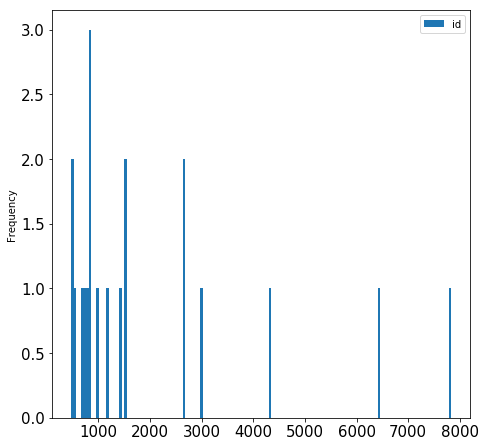

In [14]:
# histogram of recepies
cuisine_per_country  = data.groupby('cuisine')['id'].nunique(dropna=True)#.sort_values(ascending=False)
cuisine_per_country = cuisine_per_country.to_frame(name=None)
cuisine_per_country.plot.hist(by=data,bins=150,figsize =(7.5,7.5),fontsize = 15)

In [15]:
# The country with the most recepies
print data.groupby(['cuisine'])['id'].count().idxmax()

italian
